In [26]:
# !pip install -r requirements.txt -q
# !pip install ipython-autotime -q

time: 409 µs (started: 2024-11-23 13:39:30 +00:00)


In [27]:
import ta
import yfinance as yf
import numpy as np
import pandas as pd
import joblib
from joblib import Parallel, delayed
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autotime

# Download historical price data for a stock
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 
           'BA', 'XOM', 'ORCL', 'META', 'BRK', 'HSBC', 'MS', 'PYPL', 'BAC', 'BLK', 'GS']
print(len(tickers))
df = [yf.download(ticker, start="2010-11-01", end="2024-11-01") for ticker in tickers]

[*********************100%***********************]  1 of 1 completed

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
26



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

time: 1.47 s (started: 2024-11-23 13:39:30 +00:00)


In [28]:
# aapl_close = df[0]["Close"].squeeze() 
# ma100 = aapl_close.rolling(100).mean()

# BB = ta.volatility.BollingerBands(aapl_close, window=20)
# high_band = BB.bollinger_hband()
# low_band = BB.bollinger_lband()
    
# plt.figure(figsize = (12,6))
# plt.plot(aapl_close)
# plt.plot(high_band, 'b')
# plt.plot(low_band, 'b')
# plt.plot(ma100, 'r')
# plt.grid(True)
# plt.title('Graph Of Moving Averages Of 100 Days and Bollinger Bands')

time: 381 µs (started: 2024-11-23 13:39:31 +00:00)


In [29]:
def process_stock(stock_data):
    """
    Process a single stock's data to calculate technical indicators
    
    Args:
        stock_data (pd.DataFrame): DataFrame containing stock data with High, Low, Close columns
        
    Returns:
        tuple: (processed DataFrame, processed values as float32 array)
    """
    # Extract price series
    adj_close_prices = stock_data["Adj Close"].squeeze()
    close_prices = stock_data["Close"].squeeze()
    high_prices = stock_data["High"].squeeze()
    low_prices = stock_data["Low"].squeeze()
    volumes = stock_data["Volume"].squeeze()
    
    # Create a copy to avoid modifying the original
    df_processed = stock_data.copy()
    
    # Calculate momentum indicators
    df_processed["RSI"] = ta.momentum.rsi(close_prices, window=14)
    df_processed["WR"] = ta.momentum.WilliamsRIndicator(high_prices, low_prices, close_prices).williams_r()
    df_processed['Price Momentum'] = close_prices.pct_change() #Series of positive or negative percentage changes can indicate upward or downward trends
    df_processed['Volume Momentum'] = volumes.pct_change()
    
    #Rolling standard deviation 20
    df_processed['SD20'] = close_prices.rolling(window=20).std()
    
    # Calculate moving averages
    df_processed["SMA7"] = close_prices.rolling(window=7).mean()
    df_processed["SMA14"] = close_prices.rolling(window=14).mean()
    df_processed["SMA21"] = close_prices.rolling(window=21).mean()    
    
    # Calculate exponential moving averages
    df_processed['EMA7'] = ta.trend.ema_indicator(close_prices, window=7)
    df_processed['EMA12'] = ta.trend.ema_indicator(close_prices, window=12)
    df_processed['EMA26'] = ta.trend.ema_indicator(close_prices, window=26)
    df_processed['EMA99'] = ta.trend.ema_indicator(close_prices, window=99)
    # df_processed['EMA200'] = ta.trend.ema_indicator(close_prices, window=200)
    
    # Calculate trend indicators
    df_processed["MACD"] = ta.trend.MACD(close_prices, window_slow=26, window_fast=12, window_sign=9).macd()
    df_processed["CCI"] = ta.trend.CCIIndicator(close_prices, high_prices, low_prices).cci()
    
    # Calculate volatility indicators
    BB = ta.volatility.BollingerBands(close_prices, window=20)
    df_processed["Upper Band"] = BB.bollinger_hband()
    df_processed["Lower Band"] = BB.bollinger_lband()
    df_processed["Ulcer Index"] = ta.volatility.UlcerIndex(close_prices).ulcer_index()
    
    # Prediction data
    df_processed["Close Next Day"] = adj_close_prices.shift(-1)
    
    # Clean and prepare final data
    df_processed.dropna(inplace=True)
    
    # Convert to float32 array
    values = df_processed.values
    return df_processed, values

def process_all_stocks(df):
    # Process all stocks in parallel
    results = Parallel(n_jobs=-1)(delayed(process_stock)(stock) for stock in df)
    # Unzip the results into separate lists
    processed_dfs, values_list = zip(*results)
    return list(processed_dfs), list(values_list)

processed_dfs, values_list = process_all_stocks(df)

time: 1.48 s (started: 2024-11-23 13:39:31 +00:00)


In [30]:
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,Price Momentum,Volume Momentum,...,EMA7,EMA12,EMA26,EMA99,MACD,CCI,Upper Band,Lower Band,Ulcer Index,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-23,10.218667,12.113929,12.150714,11.998214,12.117143,372996400,45.129882,-63.484871,-0.005891,0.144432,...,12.137330,12.220855,12.323176,11.967859,-0.102321,-80.420297,13.019069,11.771967,4.863905,10.392805
2011-03-24,10.392805,12.320357,12.357143,12.102143,12.208929,404712000,49.916460,-47.161812,0.017041,0.085029,...,12.183087,12.236163,12.322967,11.974908,-0.086804,-35.979998,13.020057,11.778443,4.925602,10.590734
2011-03-25,10.590734,12.555000,12.573571,12.393571,12.431071,448910000,54.748644,-18.818231,0.019045,0.109209,...,12.276065,12.285215,12.340155,11.986510,-0.054940,27.787938,13.029675,11.780896,4.902553,10.557595
2011-03-28,10.557595,12.515714,12.654286,12.515714,12.612500,309355200,53.812478,-19.986852,-0.003129,-0.310875,...,12.335977,12.320676,12.353159,11.997094,-0.032483,43.028670,13.019562,11.781116,4.878158,10.573259
2011-03-29,10.573259,12.534286,12.534286,12.359286,12.416429,352900800,54.211076,-18.266099,0.001484,0.140762,...,12.385554,12.353539,12.366576,12.007838,-0.013037,21.363801,13.024466,11.782105,4.850004,10.503066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,230.316620,230.570007,230.820007,228.410004,229.979996,31109500,52.271541,-42.821761,-0.000823,-0.405024,...,232.353797,231.616284,229.395186,218.972029,2.221098,6.967201,237.468117,222.290882,2.031275,231.155685
2024-10-25,231.155685,231.410004,233.220001,229.570007,229.740005,38802300,53.621399,-42.696626,0.003643,0.247281,...,232.117849,231.584548,229.544431,219.220789,2.040117,34.671127,237.613735,222.507266,1.664750,233.143494


time: 25.9 ms (started: 2024-11-23 13:39:33 +00:00)


In [31]:
# #Create ARIMA Feature for each stock
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_absolute_error

# def apply_arima_forecasting(dfs_list):
#     """
#     Apply ARIMA forecasting to each dataframe in the list and save predictions
    
#     Parameters:
#     dfs_list (list): List of pandas DataFrames
    
#     Returns:
#     list: List of DataFrames with ARIMA predictions added
#     """
#     for i in range(len(dfs_list)):
#         # Store the last column (close next day) Y
#         last_col = dfs_list[i].columns[-1]
#         last_col_values = dfs_list[i][last_col].copy()
#         dfs_list[i].drop(columns=[last_col], inplace=True)
        
#         # Get the series from second column
#         series = dfs_list[i].iloc[:, 0]
#         X = series.values
        
#         # Split into train and test sets
#         size = int(len(X) * 0.8)
#         train, test = X[0:size], X[size:len(X)]
        
#         # Create history list for predictions
#         history = [x for x in train]
#         predictions = []
        
#         # Walk forward over time steps in test
#         for t in range(len(test)):    
#             # Fit model
#             model = ARIMA(history, order=(5,1,0))
#             model_fit = model.fit()
            
#             # Make prediction
#             output = model_fit.forecast()
#             yhat = output[0]
#             predictions.append(yhat)
            
#             # Add actual observation to history for next loop
#             obs = test[t]
#             history.append(obs)
        
#         # Add predictions to original dataframe
#         # First, create array of NaN values for training period
#         full_predictions = np.array([np.nan] * len(train) + predictions)
        
#         # Add predictions to dataframe
#         dfs_list[i]['ARIMA Output'] = full_predictions
#         dfs_list[i][last_col] = last_col_values
#         dfs_list[i].dropna(inplace=True)
        
#         # Calculate and print MAE for this dataset
#         mae = np.sqrt(mean_absolute_error(test, predictions))
#         print(f'Dataset {i} MAE: {mae: .4f}')
    
#     return dfs_list

# processed_dfs = apply_arima_forecasting(processed_dfs)

time: 769 µs (started: 2024-11-23 13:39:33 +00:00)


In [32]:
# import numpy as np
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_absolute_error
# from joblib import Parallel, delayed
# import warnings
# warnings.filterwarnings('ignore')

# def process_single_dataframe(df, index):
#     """
#     Process a single dataframe with ARIMA forecasting
#     """
#     # Store the last column (close next day) Y
#     last_col = df.columns[-1]
#     last_col_values = df[last_col].copy()
#     df = df.drop(columns=[last_col])
    
#     # Get the series from second column
#     series = df.iloc[:, 0]
#     X = series.values
    
#     # Split into train and test sets
#     size = int(len(X) * 0.8)
#     train, test = X[0:size], X[size:len(X)]
        
#     # Create history list for predictions
#     history = [x for x in train]
#     predictions = []
    
#     # Walk forward over time steps in test
#     for t in range(len(test)):    
#         # Fit model
#         model = ARIMA(history, order=(5,1,0))
#         model_fit = model.fit()
        
#         # Make prediction
#         output = model_fit.forecast()
#         yhat = output[0]
#         predictions.append(yhat)
            
#         # Add actual observation to history for next loop
#         obs = test[t]
#         history.append(obs)
    
#     # Add predictions to original dataframe
#     # First, create array of NaN values for training period
#     full_predictions = np.array([np.nan] * len(train) + predictions)
    
#     # Create result DataFrame
#     df['ARIMA Output'] = full_predictions
#     df[last_col] = last_col_values
#     # df.dropna(inplace=True)
    
#     # Calculate MAE
#     mae = np.sqrt(mean_absolute_error(test, predictions))
#     return df, mae

# def apply_arima_forecasting(dfs_list, n_jobs=-1):
#     """
#     Apply ARIMA forecasting to each dataframe in the list using parallel processing
    
#     Parameters:
#     dfs_list (list): List of pandas DataFrames
#     n_jobs (int): Number of jobs for parallel processing. -1 uses all available cores
    
#     Returns:
#     list: List of DataFrames with ARIMA predictions added
#     """
#     # Process all dataframes in parallel
#     results = Parallel(n_jobs=n_jobs)(
#         delayed(process_single_dataframe)(df.copy(), i) 
#         for i, df in enumerate(dfs_list)
#     )
    
#     # Unpack results
#     processed_dfs = []
#     for i, (df, mae) in enumerate(results):
#         processed_dfs.append(df)
#         print(f'Dataset {i} MAE: {mae:.4f}')
#     return processed_dfs

# processed_dfs = apply_arima_forecasting(processed_dfs)

time: 1.18 ms (started: 2024-11-23 13:39:33 +00:00)


In [33]:
# for i in range(len(processed_dfs)):
#     processed_dfs[i].dropna(inplace=True)

time: 690 µs (started: 2024-11-23 13:39:33 +00:00)


In [34]:
# plt.figure(figsize=(12, 6), dpi=100)
# plt.plot(processed_dfs[0]['ARIMA Output'], label='Real')
# plt.plot(processed_dfs[0]['Close Next Day'], color='red', label='Predicted')
# plt.xlabel('Days')
# plt.ylabel('USD')
# plt.title('Figure 5: ARIMA model on AAPLE stock')
# plt.legend()
# plt.show()

time: 331 µs (started: 2024-11-23 13:39:33 +00:00)


In [35]:
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,Price Momentum,Volume Momentum,...,EMA7,EMA12,EMA26,EMA99,MACD,CCI,Upper Band,Lower Band,Ulcer Index,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-23,10.218667,12.113929,12.150714,11.998214,12.117143,372996400,45.129882,-63.484871,-0.005891,0.144432,...,12.137330,12.220855,12.323176,11.967859,-0.102321,-80.420297,13.019069,11.771967,4.863905,10.392805
2011-03-24,10.392805,12.320357,12.357143,12.102143,12.208929,404712000,49.916460,-47.161812,0.017041,0.085029,...,12.183087,12.236163,12.322967,11.974908,-0.086804,-35.979998,13.020057,11.778443,4.925602,10.590734
2011-03-25,10.590734,12.555000,12.573571,12.393571,12.431071,448910000,54.748644,-18.818231,0.019045,0.109209,...,12.276065,12.285215,12.340155,11.986510,-0.054940,27.787938,13.029675,11.780896,4.902553,10.557595
2011-03-28,10.557595,12.515714,12.654286,12.515714,12.612500,309355200,53.812478,-19.986852,-0.003129,-0.310875,...,12.335977,12.320676,12.353159,11.997094,-0.032483,43.028670,13.019562,11.781116,4.878158,10.573259
2011-03-29,10.573259,12.534286,12.534286,12.359286,12.416429,352900800,54.211076,-18.266099,0.001484,0.140762,...,12.385554,12.353539,12.366576,12.007838,-0.013037,21.363801,13.024466,11.782105,4.850004,10.503066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,230.316620,230.570007,230.820007,228.410004,229.979996,31109500,52.271541,-42.821761,-0.000823,-0.405024,...,232.353797,231.616284,229.395186,218.972029,2.221098,6.967201,237.468117,222.290882,2.031275,231.155685
2024-10-25,231.155685,231.410004,233.220001,229.570007,229.740005,38802300,53.621399,-42.696626,0.003643,0.247281,...,232.117849,231.584548,229.544431,219.220789,2.040117,34.671127,237.613735,222.507266,1.664750,233.143494


time: 22.5 ms (started: 2024-11-23 13:39:33 +00:00)


In [37]:
def process_fourier_feature(stock_data):
    """
    Process a single stock's data to calculate technical indicators and Fourier components
    
    Args:
        stock_data (pd.DataFrame): DataFrame containing stock data with High, Low, Close, Volume columns
        
    Returns:
        tuple: (processed DataFrame with Fourier features, processed values as float32 array)
    """
    # Extract price series
    close_prices = stock_data["Close"].squeeze()
    high_prices = stock_data["High"].squeeze()
    low_prices = stock_data["Low"].squeeze()
    volumes = stock_data["Volume"].squeeze()
    
    # Create a copy to avoid modifying the original
    df_processed = stock_data.copy()
    
    # Calculate Fourier transform of close prices
    close_fft = np.fft.fft(np.asarray(close_prices.tolist()))
    
    # Calculate basic Fourier statistics
    df_processed['Fourier Power'] = np.abs(close_fft)
    df_processed['Fourier Phase'] = np.angle(close_fft)
    
    # Create Fourier components features
    components_to_keep = [3, 6, 9, 100]
    for num_comp in components_to_keep:
        # Create copy of FFT list and zero out other frequencies
        fft_filtered = np.copy(close_fft)
        fft_filtered[num_comp:-num_comp] = 0
        
        # Inverse FFT to get the filtered signal
        ifft_signal = np.fft.ifft(fft_filtered)
        
        # Add real parts as features
        df_processed[f'Fourier {num_comp} Real'] = np.real(ifft_signal)
    
    # Add magnitude-threshold based features
    magnitude_threshold = 0.1 * np.max(np.abs(close_fft))
    significant_fft = np.copy(close_fft)
    significant_fft[np.abs(significant_fft) < magnitude_threshold] = 0
    ifft_significant = np.fft.ifft(significant_fft)
    
    # Add significant components features
    df_processed['Fourier Significant real'] = np.real(ifft_significant)
    
    # Drop any NaN values that might have been created
    df_processed.drop(df_processed.columns[0:6], axis=1, inplace=True)
    df_processed.dropna(inplace=True)
    
    # Convert to float32 array
    values = df_processed.values
    
    return df_processed, values

def process_all_stocks_2(df):
    # Process all stocks in parallel
    results = Parallel(n_jobs=-1)(delayed(process_fourier_feature)(stock) for stock in df)
    # Unzip the results into separate lists
    processed_dfs, values_list = zip(*results)
    return list(processed_dfs), list(values_list)

# Process all stocks in parallel
fourier_results = Parallel(n_jobs=-1)(delayed(process_fourier_feature)(stock) for stock in df)
fourier_dfs, fourier_values_list = process_all_stocks_2(df)

time: 364 ms (started: 2024-11-23 13:43:17 +00:00)


In [38]:
fourier_dfs[0]

Price,Fourier Power,Fourier Phase,Fourier 3 Real,Fourier 6 Real,Fourier 9 Real,Fourier 100 Real,Fourier Significant real
Ticker,,,,,,,
Date,,,,,,,
2010-11-01,251631.774299,-1.538938e-17,103.455338,111.358324,112.276514,116.801757,110.981131
2010-11-02,124820.678654,1.066690e+00,103.178303,110.732082,111.322849,104.115764,110.421139
2010-11-03,63404.740343,1.633357e+00,102.901189,110.105361,110.368572,91.588075,109.860705
2010-11-04,25255.645241,1.559314e+00,102.623999,109.478189,109.413769,79.356255,109.299848
2010-11-05,26178.111649,1.048381e+00,102.346735,108.850595,108.458526,67.552176,108.738590
...,...,...,...,...,...,...,...
2024-10-25,30163.314500,-1.569032e+00,104.839212,114.481354,117.032685,177.737174,113.773702
2024-10-28,26178.111649,-1.048381e+00,104.562621,113.857934,116.083356,166.331105,113.216242


time: 13.2 ms (started: 2024-11-23 13:43:18 +00:00)


In [39]:
def plot_fourier_components(stock_data, figsize=(15, 10)):
    """
    Plot real parts of Fourier components and significant components
    
    Args:
        stock_data (pd.DataFrame): DataFrame containing stock price data with Close column
        figsize (tuple): Figure size for the plot
    """
    # Get close prices
    close_prices = stock_data["Close"].squeeze()
    
    # Calculate FFT
    close_fft = np.fft.fft(np.asarray(close_prices.tolist()))
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot Fourier components
    components = [3, 6, 9, 100]
    colors = ['blue', 'orange', 'green', 'red']
    
    for num_, color in zip(components, colors):
        # Filter FFT
        fft_filtered = np.copy(close_fft)
        fft_filtered[num_:-num_] = 0
        
        # Inverse FFT and get real part
        ifft_signal = np.fft.ifft(fft_filtered)
        
        plt.plot(ifft_signal, 
                label=f'Fourier {num_} components', 
                alpha=0.7,
                color=color)
    
    # Add significant components
    magnitude_threshold = 0.1 * np.max(np.abs(close_fft))
    significant_fft = np.copy(close_fft)
    significant_fft[np.abs(significant_fft) < magnitude_threshold] = 0
    ifft_significant = np.fft.ifft(significant_fft)
    
    plt.plot(ifft_significant, 
            label='Significant components', 
            alpha=0.7,
            color='orange',
            linestyle='--')
    
    # Plot original data
    plt.plot(close_prices.values, label='Original', color='purple')
    
    plt.title('Fourier Components Decomposition')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# plot_fourier_components(processed_dfs[5][2000:3000])
# plt.show()

time: 1.37 ms (started: 2024-11-23 13:43:18 +00:00)


In [40]:
def combine_dataframes_and_values(processed_dfs, fourier_dfs):
    """
    Combines two lists of dataframes using proper index alignment
    
    Args:
        processed_dfs: List of dataframes with date index
        fourier_dfs: List of dataframes with date index
    """
    combined_dfs = []
    combined_values = []
    
    for df1, df2 in zip(processed_dfs, fourier_dfs):
        # Make sure both dataframes have datetime index
        df1.index = pd.to_datetime(df1.index)
        df2.index = pd.to_datetime(df2.index)
        
        # Store the last column of df1
        last_col = df1.columns[-1]
        last_col_values = df1[last_col].copy()
        
        # Remove the last column from df1
        df1_without_last = df1.drop(columns=[last_col])
        
        # Merge on index (dates)
        df_combined = df1_without_last.join(df2, how='outer')
        
        # Add the last column back
        df_combined[last_col] = last_col_values
        
        #sort by oldest date
        df_combined = df_combined.sort_index(ascending=True)
        df_combined.dropna(inplace=True)
        
        # Replace infinite values with NaN
        # df_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
        # Fill NaN values (e.g., with the column mean or a specific value)
        # df_combined.fillna(df_combined.mean(), inplace=True)
        
        # Define thresholds
        max_threshold = 1e6
        min_threshold = -1e6

        # Clip values to the threshold
        df_combined = df_combined.clip(lower=min_threshold, upper=max_threshold)
        
        if not np.isfinite(df_combined.values).all():
            print("Warning: Data contains NaN or infinite values")
        
        combined_dfs.append(df_combined)
        combined_values.append(df_combined.values.astype('float64'))
    
    return combined_dfs, combined_values

combined_dfs, combined_values = combine_dataframes_and_values(processed_dfs, fourier_dfs)

time: 592 ms (started: 2024-11-23 13:43:18 +00:00)


In [41]:
combined_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,Price Momentum,Volume Momentum,...,Lower Band,Ulcer Index,Fourier Power,Fourier Phase,Fourier 3 Real,Fourier 6 Real,Fourier 9 Real,Fourier 100 Real,Fourier Significant real,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-23,10.218667,12.113929,12.150714,11.998214,12.117143,1000000.0,45.129882,-63.484871,-0.005891,0.144432,...,11.771967,4.863905,2111.334350,1.392614,76.392495,51.985778,28.238596,13.803875,57.162874,10.392805
2011-03-24,10.392805,12.320357,12.357143,12.102143,12.208929,1000000.0,49.916460,-47.161812,0.017041,0.085029,...,11.778443,4.925602,2134.212905,1.789320,76.122099,51.443870,27.594235,14.532931,56.657213,10.590734
2011-03-25,10.590734,12.555000,12.573571,12.393571,12.431071,1000000.0,54.748644,-18.818231,0.019045,0.109209,...,11.780896,4.902553,1839.287828,1.943577,75.851917,50.904061,26.956050,15.176440,56.153055,10.557595
2011-03-28,10.557595,12.515714,12.654286,12.515714,12.612500,1000000.0,53.812478,-19.986852,-0.003129,-0.310875,...,11.781116,4.878158,1315.513538,2.037743,75.581952,50.366372,26.324077,15.715188,55.650416,10.573259
2011-03-29,10.573259,12.534286,12.534286,12.359286,12.416429,1000000.0,54.211076,-18.266099,0.001484,0.140762,...,11.782105,4.850004,1206.374877,2.010800,75.312206,49.830824,25.698351,16.133638,55.149313,10.503066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,230.316620,230.570007,230.820007,228.410004,229.979996,1000000.0,52.271541,-42.821761,-0.000823,-0.405024,...,222.290882,2.031275,21857.804244,-1.509946,105.115706,115.104123,117.980892,188.509112,114.330593,231.155685
2024-10-25,231.155685,231.410004,233.220001,229.570007,229.740005,1000000.0,53.621399,-42.696626,0.003643,0.247281,...,222.507266,1.664750,30163.314500,-1.569032,104.839212,114.481354,117.032685,177.737174,113.773702,233.143494


time: 31.9 ms (started: 2024-11-23 13:43:19 +00:00)


In [42]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close Next Day']
    X = data.iloc[:, :-1]
    
    train_samples = int(X.shape[0] * 0.8)
    
    train_X = X.iloc[:train_samples]
    test_X = X.iloc[train_samples:]

    train_y = y.iloc[:train_samples]
    test_y = y.iloc[train_samples:]
    
    return (train_X, train_y), (test_X, test_y)

(train_X, train_y), (test_X, test_y) = get_feature_importance_data(combined_dfs[0])

time: 4.26 ms (started: 2024-11-23 13:43:19 +00:00)


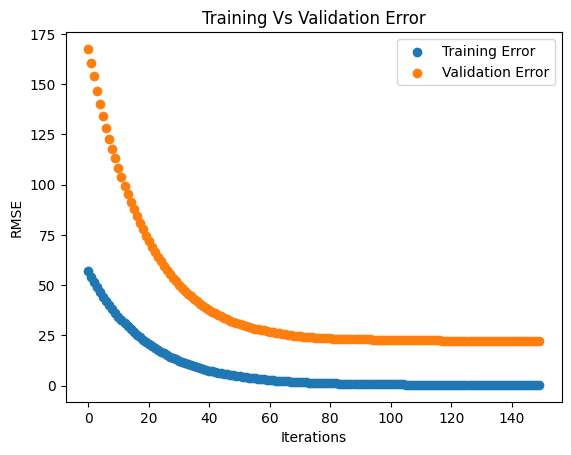

time: 8.19 s (started: 2024-11-23 13:43:21 +00:00)


In [43]:
import xgboost as xgb

regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(train_X, train_y,
                         eval_set = [(train_X, train_y), (test_X, test_y)],
                         verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

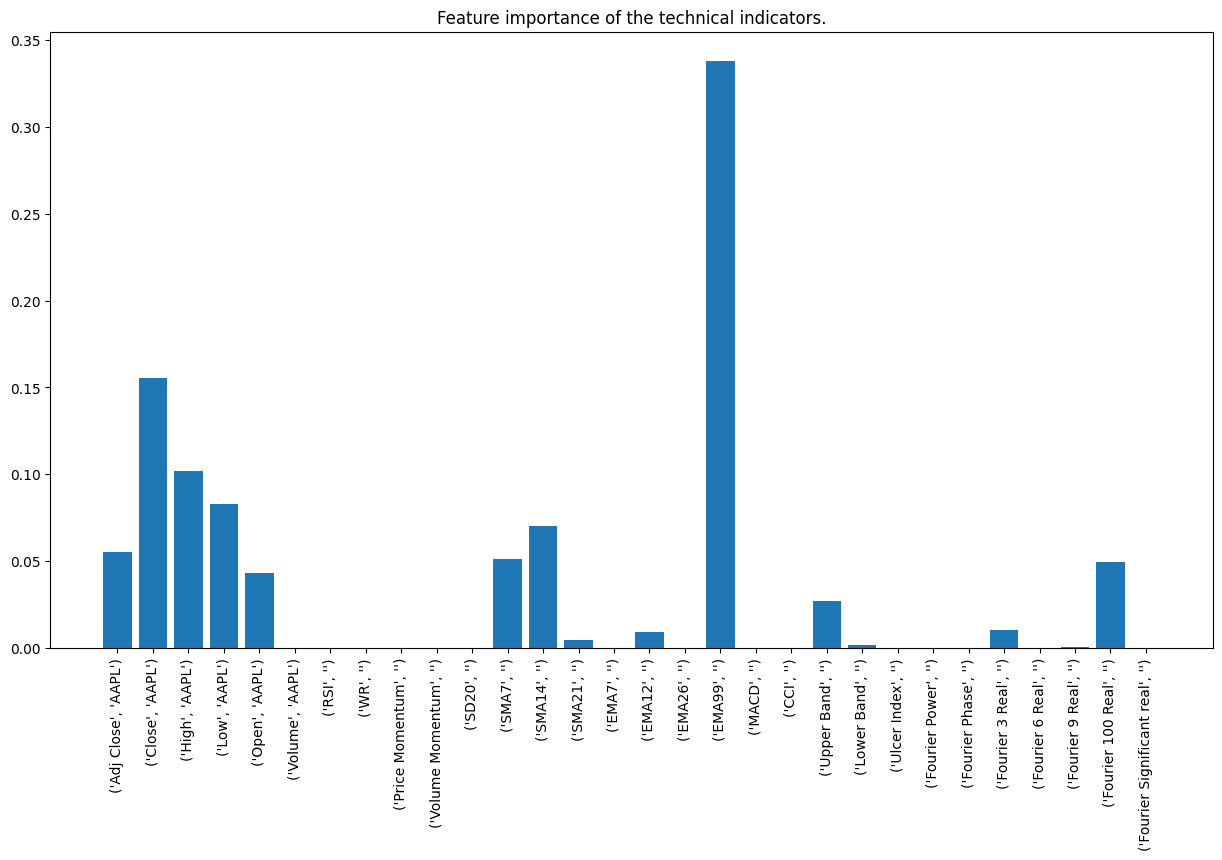

time: 325 ms (started: 2024-11-23 13:43:29 +00:00)


In [44]:
fig = plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=test_X.columns)
plt.title('Feature importance of the technical indicators.')
plt.show()

In [45]:
def save_processed_data(processed_dfs='', values_list='', output_dir='processed_data'):
    """
    Save processed DataFrames list and numpy arrays list to single files
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Save list of DataFrames using pickle
    with open(output_path / 'processed_dfs.pkl', 'wb') as f:
        joblib.dump(processed_dfs, f)
    
    # Save numpy arrays
    with open(output_path / 'values_array.pkl', 'wb') as f:
        joblib.dump(values_list, f)

def load_processed_data(data_dir='processed_data'):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / 'processed_dfs.pkl', 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    values_path = data_path / 'values_array.npy'
    values_list = np.load(values_path, allow_pickle=True)
    
    return processed_dfs, values_list

# Save both lists
save_processed_data(combined_dfs, combined_values, 'processed_data')

# Later load them
# loaded_dfs, loaded_values = load_processed_data('processed_data')

time: 82.1 ms (started: 2024-11-23 13:43:29 +00:00)
